# Experiment 3 Active Learning

### Imports

In [28]:
import itertools
from typing import Tuple

import instancelib as il
import pandas as pd
import numpy as np
from allib.activelearning.base import ActiveLearner
from allib.activelearning.mostcertain import LabelMaximizer
from allib.activelearning.uncertainty import LabelUncertainty
from allib.analysis.plotter import AbstractPlotter, ClassificationPlotter
from allib.analysis.simulation import multilabel_all_non_empty
from allib.environment.base import IT
from allib.environment.memory import MemoryEnvironment
from allib.stopcriterion.base import AbstractStopCriterion
from allib.stopcriterion.heuristic import DocCountStopCritertion, AllDocsCriterion
from instancelib.analysis.base import classifier_performance
from instancelib.typehints.typevars import DT, KT, LT, RT, VT
from instancelib.machinelearning.sklearn import SkLearnClassifier
from instancelib.typehints.typevars import KT, LT
from instancelib.utils.func import list_unzip

from sklearn.feature_extraction.text import TfidfVectorizer  # type: ignore
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, fbeta_score


from typing import Any, FrozenSet, Sequence, Tuple

from activelearning import SyntheticAssistedAL
from sbert import PretrainedSentenceBERTVectorizer
from stratified import stratified_train_test
from synthesizer import PreSynthesized

import matplotlib.pyplot as plt

In [ ]:
random.seed(20)

### Define functions

In [11]:
def simulate_classification(learner: ActiveLearner[IT, KT, DT, VT, RT, LT],
             stop_crit: AbstractStopCriterion[LT],
             plotter: AbstractPlotter[LT],
             batch_size: int, start_count=2) -> Tuple[ActiveLearner[IT, KT, DT, VT, RT, LT],
                         AbstractPlotter[LT]]:
    """Simulates the Active Learning procedure

    Parameters
    ----------
    learner : ActiveLearner[IT, KT, DT, VT, RT, LT]
        The Active Learning object
    stop_crit : AbstractStopCriterion[LT]
        The stopping criterion
    plotter : BinaryPlotter[LT]
        A plotter that tracks the results
    batch_size : int
        The batch size of each sample 
    start_count : int
        The number of instances that each class recieves before training the classification process. 

    Returns
    -------
    Tuple[ActiveLearner[IT, KT, DT, VT, RT, LT], AbstractPlotter[LT]]
        A tuple consisting of the final model and the plot of the process
    """
    learner.update_ordering()
    while not multilabel_all_non_empty(learner, start_count):
        instance = next(learner)
        oracle_labels = learner.env.truth.get_labels(instance)
        # Set the labels in the active learner
        learner.env.labels.set_labels(instance, *oracle_labels)
        learner.set_as_labeled(instance)
    while not stop_crit.stop_criterion:
        # Train the model
        learner.update_ordering()
        # Sample batch_size documents from the learner
        sample = itertools.islice(learner, batch_size)
        for instance in sample:
            # Retrieve the labels from the oracle
            oracle_labels = learner.env.truth.get_labels(instance)
            
            learner.env.labels.set_labels(instance, *oracle_labels)
            learner.set_as_labeled(instance)
        print(len(learner.env.labeled))
        plotter.update(learner)
        stop_crit.update(learner)
    
    return learner, plotter

In [24]:
def sklearn_truth_pred(model: SkLearnClassifier[Any, KT, Any, Any, LT],
                       predictions: Sequence[Tuple[KT, FrozenSet[LT]]],
                       truth: il.LabelProvider[KT, LT]) -> Tuple[np.ndarray, np.ndarray]:
    '''Return true and predicted labels from test set'''
    keys, preds = list_unzip(predictions)
    truths = [truth.get_labels(key) for key in keys]
    y_pred = model.encoder.encode_batch(preds)
    y_true = model.encoder.encode_batch(truths)
    return y_true, y_pred

### Load data

In [2]:
df = pd.read_csv("../../data/active_learning_data_to_test_imbalanced_with_identifiers.csv")
tweet_env = il.pandas_to_env_with_id(df, "identifier", "clean_post", "set")

In [ ]:
lookup_table = pd.read_csv("synthetic_data_ivae_new.csv")

### Preparation

*Split data in train and testset*

In [3]:
# We create a train set of 70 %. 
# The remainder will be used as evaluation
train, test = stratified_train_test(tweet_env, tweet_env.dataset, tweet_env.labels, 0.70)

*Create active learning environment*

In [4]:
# Here, we make an AL environment. The instances in the train set become unlabeled.
al_env = MemoryEnvironment.from_instancelib_simulation_heldout(
    tweet_env, train)

*Vectorize data with RobBERT*

In [6]:
sbert_vec = il.TextInstanceVectorizer(PretrainedSentenceBERTVectorizer("pdelobelle/robbert-v2-dutch-base"))

In [7]:
il.vectorize(sbert_vec, tweet_env, fit = False, chunk_size=20000)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

*Create synthesizer*

In [8]:
#Makes sure X amount of synthetic texts will be added per labeled COVID-19 tweet.
synthesizer = PreSynthesized(al_env, lookup_table, sbert_vec, 5)

*Initialize classifier*

In [5]:
logreg = LogisticRegression(max_iter=1000)
ml_model = il.SkLearnVectorClassifier.build(logreg, tweet_env)

*Define everything needed for active learning*

In [9]:
al = SyntheticAssistedAL(ml_model, 
                         LabelMaximizer(), 
                         "covid", 
                         synthesizer, ["covid"])(al_env)

In [10]:
# This object will track the classification performance
plotter = ClassificationPlotter(test, al.env.truth)
# The process will be terminated after all documents have been labeled
stop = AllDocsCriterion()

### Active learning

In [30]:
simulate_classification(al, stop, plotter, 20, 2)

(<activelearning.SyntheticAssistedAL at 0x139aedbcd60>,
 <allib.analysis.plotter.ClassificationPlotter at 0x139aedbc7f0>)

### Inspect results

*Final performance*

In [13]:
performance = classifier_performance(al.classifier, test, al.env.truth)

In [14]:
print(f"F1 score: {performance['covid'].f1}")
print(f"F2 score: {performance['covid'].f_beta(2)}")
print(f"Recall: {performance['covid'].recall}")
print(f"Precision: {performance['covid'].precision}")
print(f"Accuracy: {performance['covid'].accuracy}")

F1 score: 0.6074895977808599
F2 score: 0.5527511357900051
Recall: 0.5214285714285715
Precision: 0.7275747508305648
Accuracy: 0.9798862828713575


In [29]:
predictions = al.classifier.predict(test)
y_true, y_pred = sklearn_truth_pred(al.classifier, predictions, al.env.truth)
    
print('Confusion matrix \n', confusion_matrix(y_true, y_pred))
print('ROC_AUC', roc_auc_score(y_true, y_pred))
print('MCC', matthews_corrcoef(y_true, y_pred))
print('F2', fbeta_score(y_true, y_pred, beta=2))

Confusion matrix 
 [[13568    82]
 [  201   219]]
ROC_AUC 0.7577106227106226
MCC 0.6062040578086441
F2 0.552751135790005


*Performance over time*

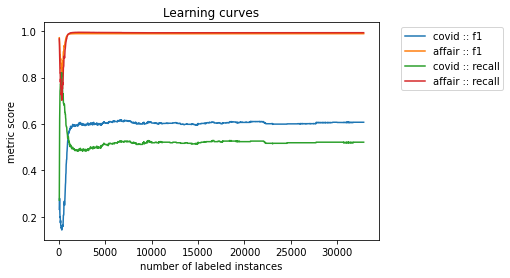

In [15]:
plotter.show()

In [16]:
plotter.result_frame

,affair_docs,affair_f1,affair_n_generated,affair_precision,affair_ratio,affair_recall,covid_docs,covid_f1,covid_n_generated,covid_precision,covid_ratio,covid_recall,n_generated_docs,n_labeled
0,63.0,0.972199,0.0,0.977345,0.840000,0.967106,12.0,0.231943,15.0,0.202487,0.160000,0.271429,15.0,75.0
1,68.0,0.957833,0.0,0.984306,0.715789,0.932747,27.0,0.279100,60.0,0.191189,0.284211,0.516667,60.0,95.0
2,68.0,0.948366,0.0,0.987393,0.591304,0.912308,47.0,0.277955,135.0,0.179012,0.408696,0.621429,135.0,115.0
3,72.0,0.916925,0.0,0.989478,0.533333,0.854286,63.0,0.218854,235.0,0.129540,0.466667,0.704762,235.0,135.0
4,77.0,0.897817,0.0,0.990455,0.496774,0.821026,78.0,0.196535,315.0,0.113249,0.503226,0.742857,315.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,31775.0,0.989679,0.0,0.985402,0.970081,0.993993,980.0,0.607490,4900.0,0.727575,0.029919,0.521429,4900.0,32755.0
1635,31795.0,0.989679,0.0,0.985402,0.970099,0.993993,980.0,0.607490,4900.0,0.727575,0.029901,0.521429,4900.0,32775.0
1636,31815.0,0.989679,0.0,0.985402,0.970117,0.993993,980.0,0.607490,4900.0,0.727575,0.029883,0.521429,4900.0,32795.0
1637,31835.0,0.989679,0.0,0.985402,0.970136,0.993993,980.0,0.607490,4900.0,0.727575,0.029864,0.521429,4900.0,32815.0


In [17]:
# plotter.result_frame.to_csv('ex3_ivae_all_docs.csv', index=False)

*Calculate F2 score progression to plot*

In [ ]:
f2_score = ((5) * plotter.result_frame['covid_precision'] * plotter.result_frame['covid_recall']) / (4 * plotter.result_frame['covid_precision'] + plotter.result_frame['covid_recall'])

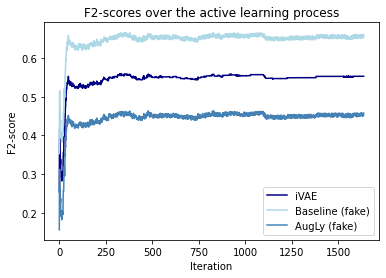

In [70]:
plt.plot(f2_score,'navy')
plt.xlabel('Iteration')
plt.ylabel('F2-score')
plt.title('F2-scores over the active learning process')
plt.show()

*Check how many labeled instances were needed for 'best' result*

In [67]:
#find (first) index of highest F2 score
[(i, score) for i, score in enumerate(f2_score) if f==max(f2_score)]

[(328, 0.5592105263157895),
 (329, 0.5592105263157895),
 (330, 0.5592105263157895),
 (331, 0.5592105263157895),
 (334, 0.5592105263157895),
 (335, 0.5592105263157895)]

In [49]:
plotter.result_frame[328:329]

,affair_docs,affair_f1,affair_n_generated,affair_precision,affair_ratio,affair_recall,covid_docs,covid_f1,covid_n_generated,covid_precision,covid_ratio,covid_recall,n_generated_docs,n_labeled
328,5815.0,0.990009,0.0,0.985552,0.876413,0.994505,820.0,0.617318,4100.0,0.746622,0.123587,0.52619,4100.0,6635.0
